In [1]:
# Loot Telemetry Analysis Dashboard
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Server configuration
SERVER_URL = "http://localhost:5000"

print("🎯 Loot Telemetry Analysis Dashboard")
print("=" * 40)
print(f"📡 Server: {SERVER_URL}")
print(f"📅 Analysis run: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n💡 This notebook analyzes data from the telemetry server.")
print("💡 Use 'python data_generator.py' to generate and upload mock data.")

🎯 Loot Telemetry Analysis Dashboard
📡 Server: http://localhost:5000
📅 Analysis run: 2025-10-28 11:14:38

💡 This notebook analyzes data from the telemetry server.
💡 Use 'python data_generator.py' to generate and upload mock data.


In [2]:
def test_server_connection():
    """Test connection to the telemetry server."""
    try:
        response = requests.get(f"{SERVER_URL}/api/health", timeout=5)
        if response.status_code == 200:
            print("✅ Server is online and responding")
            return True
        else:
            print(f"⚠️  Server responded with status {response.status_code}")
            return False
    except requests.ConnectionError:
        print("❌ Cannot connect to server")
        print("💡 Make sure the server is running: python server.py")
        return False
    except Exception as e:
        print(f"❌ Connection error: {e}")
        return False

def get_server_stats():
    """Fetch aggregate statistics from the server."""
    try:
        response = requests.get(f"{SERVER_URL}/api/aggregate", timeout=5)
        if response.status_code == 200:
            return response.json()['data']
        else:
            print(f"❌ Failed to get stats: HTTP {response.status_code}")
            return None
    except Exception as e:
        print(f"❌ Error fetching stats: {e}")
        return None

# Test connection and show initial server status
if test_server_connection():
    stats = get_server_stats()
    if stats:
        print(f"\n📊 Current Server Data:")
        print(f"   📋 {stats['total_stat_sheets']} total stat sheets")
        print(f"   🎮 {stats['total_matches']} unique matches") 
        print(f"   👥 {stats['total_players']} unique players")
        print(f"   🎁 Total items collected: {sum(stats['total_items'].values())}")
        print(f"   📈 Item breakdown: {stats['total_items']}")
    else:
        print("⚠️  No data available or server error")
else:
    print("\n🚨 Cannot proceed with analysis - server is not available")

✅ Server is online and responding

📊 Current Server Data:
   📋 1602 total stat sheets
   🎮 51 unique matches
   👥 201 unique players
   🎁 Total items collected: 20116
   📈 Item breakdown: {'ammo_box': 3927, 'gold_coin': 4010, 'grenade': 4040, 'medkit': 4129, 'rubber_duck': 4010}

📊 Current Server Data:
   📋 1602 total stat sheets
   🎮 51 unique matches
   👥 201 unique players
   🎁 Total items collected: 20116
   📈 Item breakdown: {'ammo_box': 3927, 'gold_coin': 4010, 'grenade': 4040, 'medkit': 4129, 'rubber_duck': 4010}


In [7]:
# Item Distribution Analysis
import os

def create_item_distribution_chart():
    """Create a chart showing the distribution of collected items."""
    stats = get_server_stats()
    if not stats or not stats['total_items']:
        print("❌ No item data available for visualization")
        return
    
    items = list(stats['total_items'].keys())
    counts = list(stats['total_items'].values())
    
    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(items, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.title('Item Collection Distribution Across All Matches', fontsize=16, fontweight='bold')
    plt.xlabel('Item Type', fontsize=12)
    plt.ylabel('Total Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Ensure outputs directory exists
    os.makedirs('outputs', exist_ok=True)
    
    # Save chart
    plt.savefig('outputs/item_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    total_items = sum(counts)
    print(f"\n📊 Item Distribution Summary:")
    print(f"   🎯 Total items collected: {total_items:,}")
    for item, count in zip(items, counts):
        percentage = (count / total_items) * 100
        print(f"   • {item}: {count:,} ({percentage:.1f}%)")

create_item_distribution_chart()

❌ Error fetching stats: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/aggregate (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000029235DD0410>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
❌ No item data available for visualization


🦆 Fetching rubber duck location data...
🦆 Creating heatmap from 4493 rubber duck locations
🦆 Creating heatmap from 4493 rubber duck locations


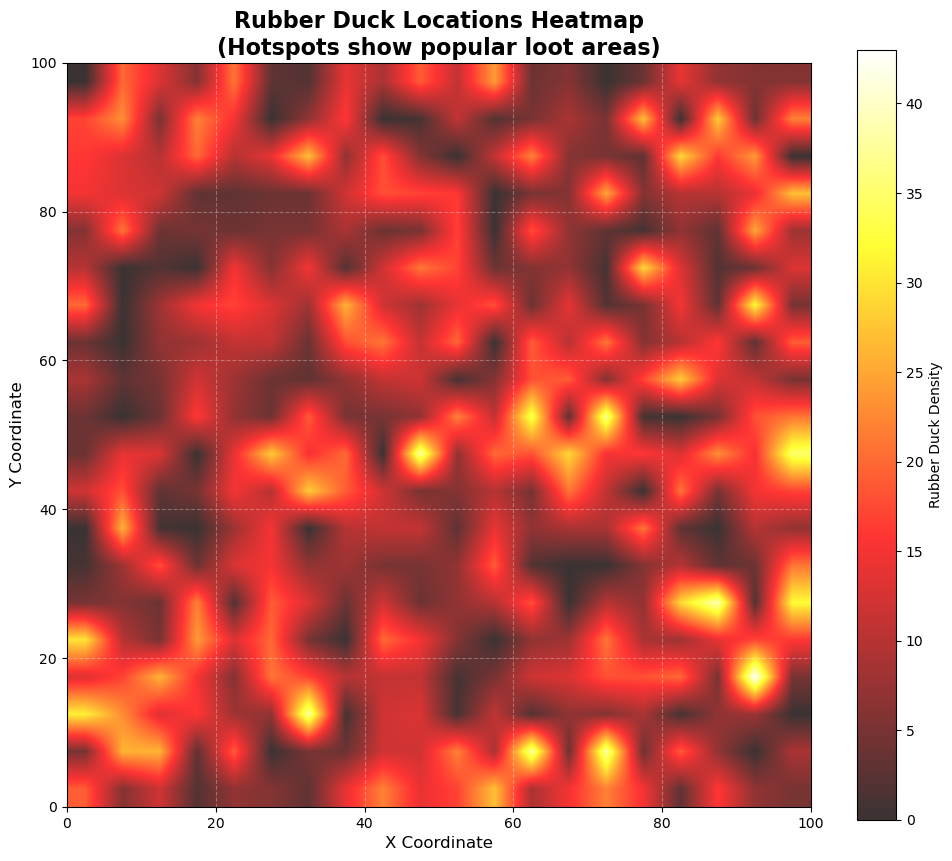


Heatmap Statistics:
   • Data points: 4493
   • X range: 0.1 - 99.9
   • Y range: 0.1 - 100.0
   • Hottest areas show where players find rubber ducks most frequently


In [ ]:
# Rubber Duck Heatmap Analysis
def create_rubber_duck_heatmap():
    """Create a heatmap showing rubber duck locations across all matches."""
    try:
        print("🦆 Fetching rubber duck location data...")
        response = requests.get(f"{SERVER_URL}/api/heatmap/rubber_duck", timeout=10)
        if response.status_code != 200:
            print(f"❌ Failed to get heatmap data: HTTP {response.status_code}")
            return
        
        heatmap_data = response.json()['data']
        locations = heatmap_data['locations']
        
        if not locations:
            print("❌ No rubber duck location data found")
            return
        
        print(f"🦆 Creating heatmap from {len(locations)} rubber duck locations")
        
        # Extract coordinates
        x_coords = [loc[0] for loc in locations]
        y_coords = [loc[1] for loc in locations]
        
        # Create heatmap
        plt.figure(figsize=(12, 10))
        
        # Create 2D histogram
        hist, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=20)
        
        # Create heatmap
        plt.imshow(hist.T, origin='lower', cmap='hot', alpha=0.8, 
                  extent=[0, 100, 0, 100], interpolation='bilinear')
        
        plt.colorbar(label='Rubber Duck Density')
        plt.title('Rubber Duck Locations Heatmap\n(Hotspots show popular loot areas)', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('X Coordinate', fontsize=12)
        plt.ylabel('Y Coordinate', fontsize=12)
        
        # Add grid for reference
        plt.grid(True, alpha=0.3, color='white', linestyle='--')
        
        # Ensure outputs directory exists
        os.makedirs('outputs', exist_ok=True)
        
        # Save heatmap
        plt.savefig('outputs/rubber_duck_heatmap.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Statistics
        print(f"\nHeatmap Statistics:")
        print(f"   • Data points: {len(locations)}")
        print(f"   • X range: {min(x_coords):.1f} - {max(x_coords):.1f}")
        print(f"   • Y range: {min(y_coords):.1f} - {max(y_coords):.1f}")
        print(f"   • Hottest areas show where players find rubber ducks most frequently")
        
    except requests.Timeout:
        print("❌ Request timed out - server may be slow or unresponsive")
    except requests.ConnectionError:
        print("❌ Cannot connect to server for heatmap data")
    except Exception as e:
        print(f"❌ Error creating heatmap: {e}")

create_rubber_duck_heatmap()

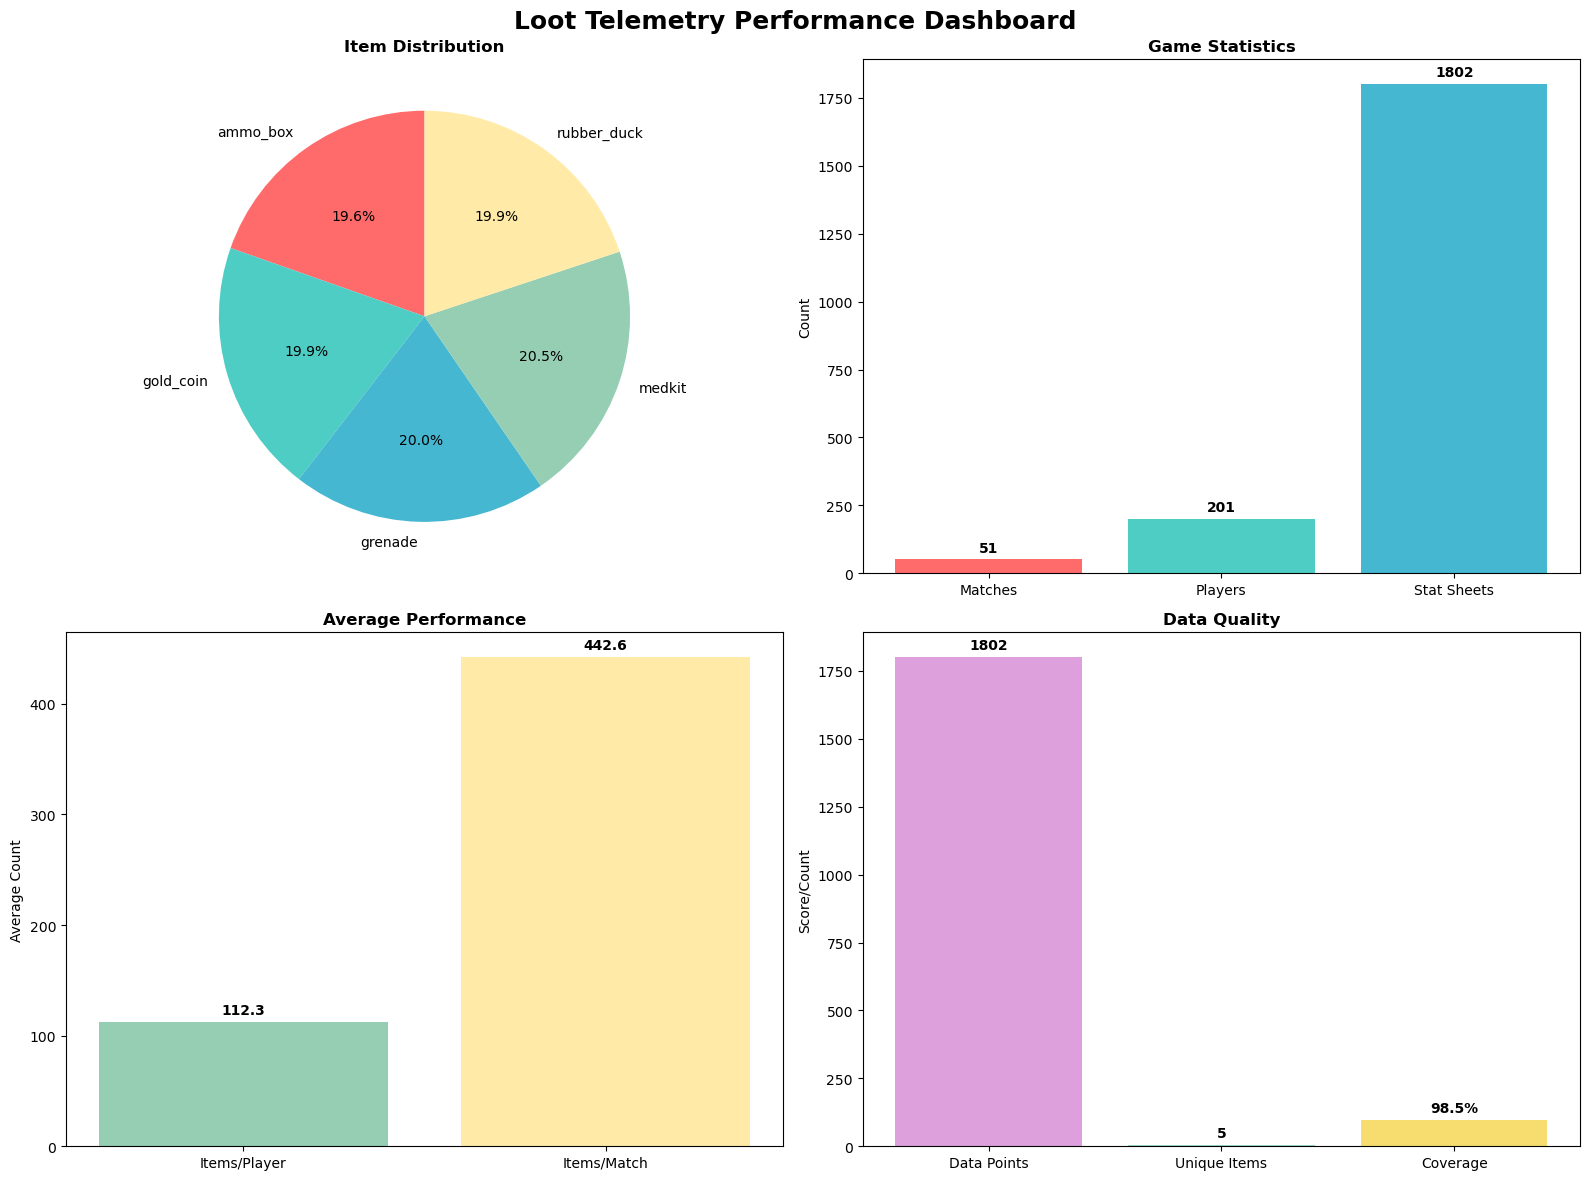


Performance Analysis Summary:
   • Total data points: 1,802
   • Match coverage: 51 matches analyzed
   • Player participation: 201 unique players
   • Average items per player: 112.30
   • Most collected item: medkit
   • Data completeness: 98.5% (assuming 4 players/match)

✅ Analysis Complete!
📁 Generated files:
   • item_distribution.png - Item collection chart
   • rubber_duck_heatmap.png - Location heatmap
   • performance_dashboard.png - Complete dashboard

💡 To generate more data: python data_generator.py --matches 100
🌐 Server API: http://localhost:5000


In [ ]:
# Match and Player Performance Analysis
def create_performance_dashboard():
    """Create a comprehensive dashboard showing match and player performance."""
    stats = get_server_stats()
    if not stats:
        print("❌ No performance data available")
        return
    
    # Create multi-panel dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Loot Telemetry Performance Dashboard', fontsize=18, fontweight='bold')
    
    # Panel 1: Item Distribution (Pie Chart)
    items = list(stats['total_items'].keys())
    counts = list(stats['total_items'].values())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    ax1.pie(counts, labels=items, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Item Distribution', fontweight='bold')
    
    # Panel 2: Summary Statistics (Bar Chart)
    summary_labels = ['Matches', 'Players', 'Stat Sheets']
    summary_values = [stats['total_matches'], stats['total_players'], stats['total_stat_sheets']]
    bars = ax2.bar(summary_labels, summary_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    
    # Add value labels
    for bar, value in zip(bars, summary_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(summary_values)*0.01,
                str(value), ha='center', va='bottom', fontweight='bold')
    
    ax2.set_title('Game Statistics', fontweight='bold')
    ax2.set_ylabel('Count')
    
    # Panel 3: Average Items per Player
    avg_items_per_player = sum(counts) / stats['total_players'] if stats['total_players'] > 0 else 0
    avg_items_per_match = sum(counts) / stats['total_matches'] if stats['total_matches'] > 0 else 0
    
    metrics = ['Items/Player', 'Items/Match']
    values = [avg_items_per_player, avg_items_per_match]
    bars = ax3.bar(metrics, values, color=['#96CEB4', '#FFEAA7'])
    
    for bar, value in zip(bars, values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    ax3.set_title('Average Performance', fontweight='bold')
    ax3.set_ylabel('Average Count')
    
    # Panel 4: Data Quality Metrics
    data_quality_labels = ['Data Points', 'Unique Items', 'Coverage']
    data_points = stats['total_stat_sheets']
    unique_items = len(items)
    coverage = (stats['total_players'] / max(stats['total_matches'] * 4, 1)) * 100  # Assuming 4 players per match
    
    quality_values = [data_points, unique_items, coverage]
    bars = ax4.bar(data_quality_labels, quality_values, color=['#DDA0DD', '#98D8C8', '#F7DC6F'])
    
    for bar, value, label in zip(bars, quality_values, data_quality_labels):
        if label == 'Coverage':
            text = f'{value:.1f}%'
        else:
            text = str(int(value))
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(quality_values)*0.01,
                text, ha='center', va='bottom', fontweight='bold')
    
    ax4.set_title('Data Quality', fontweight='bold')
    ax4.set_ylabel('Score/Count')
    
    plt.tight_layout()
    
    # Ensure outputs directory exists
    os.makedirs('outputs', exist_ok=True)
    
    # Save dashboard
    plt.savefig('outputs/performance_dashboard.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print detailed analysis
    print(f"\nPerformance Analysis Summary:")
    print(f"   • Total data points: {stats['total_stat_sheets']:,}")
    print(f"   • Match coverage: {stats['total_matches']} matches analyzed")
    print(f"   • Player participation: {stats['total_players']} unique players")
    print(f"   • Average items per player: {avg_items_per_player:.2f}")
    print(f"   • Most collected item: {max(items, key=lambda x: stats['total_items'][x])}")
    print(f"   • Data completeness: {coverage:.1f}% (assuming 4 players/match)")

create_performance_dashboard()

print("\n" + "="*60)
print("✅ Analysis Complete!")
print("📁 Generated files in 'outputs/' folder:")
print("   • outputs/item_distribution.png - Item collection chart")
print("   • outputs/rubber_duck_heatmap.png - Location heatmap") 
print("   • outputs/performance_dashboard.png - Complete dashboard")
print("\n💡 To generate more data: python data_generator.py --matches 100")
print("🌐 Server API: http://localhost:5000")